# AgentTorch Simulation Analysis Tutorial

This tutorial demonstrates how to use an LLM agent to query the history of a simulation using the AgentTorch framework.

## 1. Import Required Libraries

In [2]:
from langchain_openai import ChatOpenAI
from agent_torch.core.analyzer.retriever import DocumentRetriever
from agent_torch.core.analyzer.utils import generate_attribute_info_list
from agent_torch.core.executor import Executor
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from agent_torch.core.dataloader import LinkPopulation
from populations import astoria
from agent_torch.models import covid
from langchain_community.vectorstores import Chroma
from agent_torch.core.analyzer.simulation_analyzer import SimulationAnalysisAgent

## 2. Set Up the Simulation Environment

In [3]:
# Set up the simulation environment
nyc_population = LinkPopulation(astoria)
simulation = Executor(model=covid, pop_loader=nyc_population)

# Set up the embedding function and vector store
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
# Set up the OpenAI API key
OPENAI_API_KEY = None

# Load configuration from YAML file
config = simulation.config

# Set up the LLM
model = "gpt-4o-mini"
llm = ChatOpenAI(model=model, temperature=0.1, openai_api_key=OPENAI_API_KEY)

# Generate metadata field info and prepare metadata
metadata_field_info = generate_attribute_info_list(data=config["simulation_metadata"], llm=llm)
metadata = config["simulation_metadata"]
metadata = {k: v for k, v in metadata.items() if not isinstance(v, (list, dict))}
metadata["description"] = "A simulation of a virus spreading through a population. This is more transmissible"

# Set up the document retriever
retriever = DocumentRetriever(
    region=astoria,
    embedding=embedding_function,
    vectorstore_type=Chroma,
)

## 4. Create and Initialize the SimulationAnalysisAgent

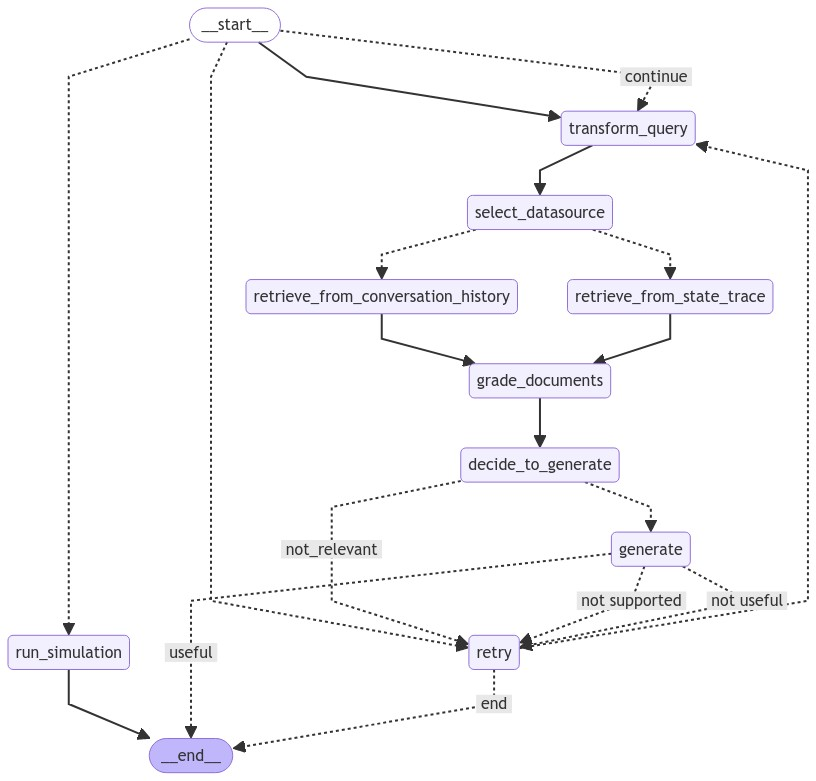

In [4]:
# Create the SimulationAnalysisAgent

analyzer = SimulationAnalysisAgent(
    openai_api_key=OPENAI_API_KEY,
    simulation=simulation, # The simulation executor
    document_retriever=retriever,
    temperature=0,
)

# Initialize the first simulation run
await analyzer.add_new_run(
    metadata=metadata,
    metadata_field_info=metadata_field_info,
)

## 5. Query the Simulation

In [ ]:
# Query the simulation
response = analyzer.query("Which age group has lowest median income, how much is it?")
print(response)

## 6. Add More Simulation Runs

In [ ]:
# Add a second simulation run with different parameters

# Set the simulation parameters for the second run
simulation.data_loader.set_config_attribute("EXPOSED_TO_INFECTED_TIME", 4)
simulation.data_loader.set_config_attribute("INFECTED_TO_RECOVERED_TIME", 6)
simulation.data_loader.set_config_attribute("INFINITY_TIME", 120)
simulation.data_loader.set_config_attribute("RECOVERED_TO_SUSCEPTIBLE_TIME", 110)
simulation.data_loader.set_config_attribute("quarantine_days", 10)
simulation.data_loader.set_config_attribute("test_result_delay_days", 4)
simulation.data_loader.set_config_attribute("test_ineligible_days", 3)

# Update the metadata for the second run, based on the new simulation parameters
metadata.update(
    {
        "EXPOSED_TO_INFECTED_TIME": 4,
        "INFECTED_TO_RECOVERED_TIME": 6,
        "INFINITY_TIME": 120,
        "RECOVERED_TO_SUSCEPTIBLE_TIME": 110,
        "quarantine_days": 10,
        "test_result_delay_days": 4,
        "test_ineligible_days": 3,
        "description": "A simulation of a virus with balanced incubation and recovery times, and moderate quarantine and testing delays.",
    }
)

# Add the second simulation run
await analyzer.add_new_run(
    metadata=metadata,
    metadata_field_info=metadata_field_info,
)


## 7. Query Across Multiple Simulation Runs

In [ ]:
# Query across multiple simulation runs
response = analyzer.query("How has the median income changed between simulations?")
print(response)

## 8. Run Speculative Queries

In [ ]:
# Query the simulation with a question about the impact of increased transmissibility
# It will update the simulation parameters based on the requirements of the question and run the simulation
analyzer.query("What would happen is isolation time is increased and virus become more transmissible?")

## Conclusion

This tutorial demonstrated how to use the SimulationAnalysisAgent to query the history of multiple simulation runs using the AgentTorch framework. You can now experiment with different queries and simulation parameters to gain insights from your simulations.